# EDA 미니 프로젝트

### 전처리 목적
본 노트북은 영화 데이터에서 **관람인원수(VIEWNG_NMPR_CO)** 를 핵심 지표로 활용하기 위해, 날짜(OPN_DE) 및 관람인원수(VIEWNG_NMPR_CO)의 형식 불일치/결측/비정상 값을 정제하고 범주형 변수(DISTB_CMPNY_NM, GENRE_NM, NLTY_NM)를 분석 가능한 형태로 표준화 하는 과정을 일관된 정책으로 수행한다.

### 전처리 설계 원칙
- 안전성 우선: 원본 컬럼은 최대한 보존하고, 정제 컬럼을 별도로 생성 후 검증 뒤 반영한다.
- 정책 기반 처리: “왜 제거/대체/표준화 했는지”를 단계별로 명시해 재현성과 설명가능성을 확보한다.
- 검증 루프 포함: 정제 전/후에 비정상 값 개수와 샘플을 확인하여 품질을 보장한다.

## 1) 기본 설정 세팅

In [1]:
# (선택) 라이브러리 설치가 안 될 때만 실행
!pip install pandas matplotlib seaborn

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

한글 폰트 설정 (Windows)

In [3]:
import matplotlib
import matplotlib.font_manager as fm

# Windows 기본 폰트 경로 예시 (환경에 따라 폰트 파일명은 다를 수 있음)
font_path = "C:\\Windows\\Fonts\\malgun.TTF"
font_prop = fm.FontProperties(fname=font_path)
font_name = font_prop.get_name()

matplotlib.rc('font', family=font_name)
plt.rc('axes', unicode_minus=False)  # 음수 기호 깨짐 방지

## 2) 데이터셋 로드

In [4]:
movie_df = pd.read_csv("./data/merged_56_utf8.csv")
movie_df.head()

,NO,MOVIE_NM,DRCTR_NM,MAKR_NM,INCME_CMPNY_NM,DISTB_CMPNY_NM,OPN_DE,MOVIE_TY_NM,MOVIE_STLE_NM,NLTY_NM,TOT_SCRN_CO,SALES_PRICE,VIEWNG_NMPR_CO,SEOUL_SALES_PRICE,SEOUL_VIEWNG_NMPR_CO,GENRE_NM,GRAD_NM,MOVIE_SDIV_NM
0,57.0,"하이큐!! 리에프 등장! & VS""낙제점""",미츠나카 스스무,NaN,에스엠지홀딩스 주식회사,에스엠지홀딩스 주식회사,20250731.0,개봉영화,장편,일본,51,14560800,2082,5703500,797,애니메이션,12세이상관람가,일반영화
1,7.0,좀비딸,필감성,스튜디오엔(주),NaN,(주)넥스트엔터테인먼트월드(NEW),20250730.0,개봉영화,장편,한국,"1,557",5915790300,703001,1134526320,131016,코미디,12세이상관람가,일반영화
2,15.0,배드 가이즈 2,피에르 페리펠,NaN,유니버설픽쳐스인터내셔널 코리아(유),유니버설픽쳐스인터내셔널 코리아(유),20250730.0,개봉영화,장편,미국,674,752128730,85757,167023150,18056,애니메이션,전체관람가,일반영화
3,28.0,고고다이노 극장판: 게코도마뱀의 꿈,이원재,(주)모꼬지,NaN,(주)모꼬지,20250730.0,개봉영화,장편,한국,179,123833400,13672,22724000,2571,애니메이션,전체관람가,일반영화
4,67.0,엣 더 벤치,오쿠야마 요시유키,NaN,(주)도키엔터테인먼트,와이드 릴리즈(주),20250730.0,개봉영화,장편,일본,34,11273000,1238,7655600,841,드라마,전체관람가,독립/예술영화


In [5]:
print(movie_df.columns.tolist())

['NO', 'MOVIE_NM', 'DRCTR_NM', 'MAKR_NM', 'INCME_CMPNY_NM', 'DISTB_CMPNY_NM', 'OPN_DE', 'MOVIE_TY_NM', 'MOVIE_STLE_NM', 'NLTY_NM', 'TOT_SCRN_CO', 'SALES_PRICE', 'VIEWNG_NMPR_CO', 'SEOUL_SALES_PRICE', 'SEOUL_VIEWNG_NMPR_CO', 'GENRE_NM', 'GRAD_NM', 'MOVIE_SDIV_NM']


In [6]:
movie_df.info()

<class 'pandas.DataFrame'>
RangeIndex: 1785 entries, 0 to 1784
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   NO                    1670 non-null   float64
 1   MOVIE_NM              1670 non-null   str    
 2   DRCTR_NM              1421 non-null   str    
 3   MAKR_NM               714 non-null    str    
 4   INCME_CMPNY_NM        888 non-null    str    
 5   DISTB_CMPNY_NM        1670 non-null   str    
 6   OPN_DE                1669 non-null   float64
 7   MOVIE_TY_NM           1670 non-null   str    
 8   MOVIE_STLE_NM         1670 non-null   str    
 9   NLTY_NM               1670 non-null   str    
 10  TOT_SCRN_CO           1670 non-null   str    
 11  SALES_PRICE           1669 non-null   str    
 12  VIEWNG_NMPR_CO        1670 non-null   str    
 13  SEOUL_SALES_PRICE     1670 non-null   str    
 14  SEOUL_VIEWNG_NMPR_CO  1670 non-null   str    
 15  GENRE_NM              1669 non-n

## 3) 중복 영화 관객 수 누적처리 및 중복 삭제

In [7]:
movie_df.describe(include="all")
# 1️⃣ 컬럼 공백 제거
movie_df.columns = movie_df.columns.str.strip()

# 2️⃣ 관객수 숫자 변환
movie_df['VIEWNG_NMPR_CO'] = (
    movie_df['VIEWNG_NMPR_CO']
    .astype(str)
    .str.replace(',', '', regex=False)
)

movie_df['VIEWNG_NMPR_CO'] = pd.to_numeric(
    movie_df['VIEWNG_NMPR_CO'],
    errors='coerce'
)

# 3️⃣ 영화별 누적 관객수 집계
result_df = movie_df.groupby(
    ['MOVIE_NM', 'DRCTR_NM', 'OPN_DE'],
    as_index=False
).agg({
    'VIEWNG_NMPR_CO': 'sum',        # 관객수 합산
    'DISTB_CMPNY_NM': 'first',      # 배급사 첫 값
    'GENRE_NM': 'first',
    'NLTY_NM': 'first',
    'GRAD_NM': 'first'
})
# 4️⃣ 확인
print(result_df.head())
print("최종 행 개수:", len(result_df))

                   MOVIE_NM   DRCTR_NM      OPN_DE  VIEWNG_NMPR_CO  \
0  (여자)아이들 월드투어 [아이돌] 인 시네마        오윤동  20250108.0          5294.0   
1                   10 라이브즈  크리스토퍼 젠킨스  20240815.0         59525.0   
2                1923 간토대학살    김태영,최규석  20240815.0         12572.0   
3                      1980        강승용  20240327.0         43967.0   
4                        1승        신연식  20241204.0        308813.0   

                     DISTB_CMPNY_NM GENRE_NM NLTY_NM   GRAD_NM  
0           씨제이포디플렉스 주식회사,씨지브이 아이스콘       공연      한국  12세이상관람가  
1                       (주)박수엔터테인먼트    애니메이션      영국     전체관람가  
2                      (주)영화특별시에스엠씨    다큐멘터리      한국  12세이상관람가  
3           (주)제이앤씨미디어그룹,와이드 릴리즈(주)      드라마      한국  12세이상관람가  
4  (주)콘텐츠지오,(주)키다리스튜디오,(주)아티스트유나이티드      드라마      한국  12세이상관람가  
최종 행 개수: 690


## 4) 데이터 전처리 2단계: 컬럼별 정리
본 단계에서는 전처리 대상 컬럼을 (1) 핵심 수치형 2개와 (2) 범주형 3개로 구분하고, 각 컬럼별로 데이터 품질 이슈 → 처리 정책 → 기대 효과를 명시한다.
목표는 “분석/시각화/모델링에 바로 투입 가능한 형태”로 형식 표준화 + 결측/비정상 관리 + 범주 축약을 일관되게 수행하는 것이다.

### 4-1) 필요한 컬럼만 선택
선택 기준
- 타깃(관람인원수): VIEWNG_NMPR_CO
- 설명변수(범주): DISTB_CMPNY_NM(배급사), GENRE_NM(장르), NLTY_NM(국적)
- 시간변수(개봉일): OPN_DE

In [8]:
use_cols = ["VIEWNG_NMPR_CO", "DISTB_CMPNY_NM", "GENRE_NM", "NLTY_NM", "OPN_DE", 'GRAD_NM']
result_df = result_df[use_cols].copy()
result_df.head()

,VIEWNG_NMPR_CO,DISTB_CMPNY_NM,GENRE_NM,NLTY_NM,OPN_DE,GRAD_NM
0,5294.0,"씨제이포디플렉스 주식회사,씨지브이 아이스콘",공연,한국,20250108.0,12세이상관람가
1,59525.0,(주)박수엔터테인먼트,애니메이션,영국,20240815.0,전체관람가
2,12572.0,(주)영화특별시에스엠씨,다큐멘터리,한국,20240815.0,12세이상관람가
3,43967.0,"(주)제이앤씨미디어그룹,와이드 릴리즈(주)",드라마,한국,20240327.0,12세이상관람가
4,308813.0,"(주)콘텐츠지오,(주)키다리스튜디오,(주)아티스트유나이티드",드라마,한국,20241204.0,12세이상관람가


In [9]:
result_df.info()

<class 'pandas.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   VIEWNG_NMPR_CO  690 non-null    float64
 1   DISTB_CMPNY_NM  690 non-null    str    
 2   GENRE_NM        690 non-null    str    
 3   NLTY_NM         690 non-null    str    
 4   OPN_DE          690 non-null    float64
 5   GRAD_NM         690 non-null    str    
dtypes: float64(2), str(4)
memory usage: 32.5 KB


### OPN_DE 컬럼

#### 컬럼 이슈 진단
**목표**

OPN_DE를 **분석 가능한 날짜형(datetime)** 으로 변환하기 위한 사전 점검.

관측된 이슈 유형(예시)

- YYYYMMDD.0 형태: 로딩 과정에서 float 흔적이 문자열로 남은 케이스
- NaN: 개봉일 정보 누락
- YYYY-MM- 형태: 연-월까지만 있고 일(day)이 비어있는 케이스
- 기타: 하이픈/공백/문자 혼입 등 비정형 케이스

1. 결측치(NaN) 개수 확인

In [10]:
nan_count = result_df["OPN_DE"].isna().sum()
print("NaN count:", nan_count)

NaN count: 0


2. 8자리(YYYYMMDD)가 아닌 값 찾기
- 정책상 최종 목표 포맷은 YYYYMMDD(8자리 숫자)로 정규화
- NaN 포함 시 문자열 함수가 예외/의도치 않은 결과를 만들 수 있으므로 astype(str)로 안전 처리 후 점검

In [11]:
mask_not_yyyymmdd = ~result_df["OPN_DE"].astype(str).str.match(r"^\d{8}$")
result_df.loc[mask_not_yyyymmdd, "OPN_DE"].head(10)

0    20250108.0
1    20240815.0
2    20240815.0
3    20240327.0
4    20241204.0
5    20240619.0
6    20250312.0
7    20240727.0
8    20250619.0
9    20241101.0
Name: OPN_DE, dtype: float64

In [12]:
print("Not YYYYMMDD count:", mask_not_yyyymmdd.sum())

Not YYYYMMDD count: 690


3. .0가 포함된 값 확인

In [13]:
mask_dot0 = result_df["OPN_DE"].astype(str).str.contains(r".0", regex=True)
result_df.loc[mask_dot0, "OPN_DE"].head(20)

print(".0 포함 count:", mask_dot0.sum())

.0 포함 count: 690


#### 정제 함수 정의
**처리 정책(Policy)**
1. OPN_DE 결측치 행은 제거
- 기준: 개봉일은 시계열/연도별 집계에서 핵심 키이며, 결측이 소수인 경우(예: 3건 수준) 데이터 손실 영향이 작다.
2. YYYYMMDD.0 → YYYYMMDD로 정리
3. YYYY-MM- → 날짜(day)가 없으므로 **해당 월의 1일(01)**을 부여하여 YYYYMM01로 정규화
- 기준: “월 단위 정보라도 살릴 가치가 있다”는 보수적 보정. (필요 시 이후 단계에서 월 단위 분석 가능)
4. 그 외 비정형 입력은 숫자만 추출 후 길이에 따라 day를 보정(방어적 처리)
- YYYYMM(6자리) → YYYYMM01
- YYYY(4자리) → YYYY0101
5. 최종적으로 8자리만 유지(과도한 길이/잡문자 유입 방지)
**반환**
- OPN_DE를 **문자열 'YYYYMMDD'**로 정제한 DataFrame

In [14]:
def clean_opn_de_to_datetime(df: pd.DataFrame, col: str = "OPN_DE") -> pd.DataFrame:
    """
    개봉일자(OPN_DE)를 정규화한 뒤 datetime64[ns]로 변환한다.

    처리 정책
    - 결측치 제거(dropna)
    - 'YYYY-MM-' -> 'YYYY-MM-01'로 보정
    - 'YYYYMMDD.0' -> '.0' 제거
    - 숫자만 남기고 길이 보정:
        * YYYYMM(6) -> YYYYMM01
        * YYYY(4)  -> YYYY0101
      이후 8자리로 절단
    - pd.to_datetime(format='%Y%m%d', errors='coerce')로 변환
    - 변환 실패(NaT) 제거

    Returns
    - col: datetime64[ns]
    """
    df = df.copy()

    # 1) 결측치 제거
    df = df.dropna(subset=[col])

    # 2) 문자열 정리
    s = df[col].astype(str).str.strip()

    # 3) 'YYYY-MM-' -> 'YYYY-MM-01'
    s = s.str.replace(r"^(\d{4})-(\d{2})-$", r"\1-\2-01", regex=True)

    # 4) '.0' 제거
    s = s.str.replace(r"\.0$", "", regex=True)

    # 5) 숫자만 남기기
    s = s.str.replace(r"\D", "", regex=True)

    # 6) 길이 보정(방어적)
    mask_6 = s.str.len().eq(6)
    s.loc[mask_6] = s.loc[mask_6] + "01"

    mask_4 = s.str.len().eq(4)
    s.loc[mask_4] = s.loc[mask_4] + "0101"

    # 7) 8자리로 제한
    s = s.str[:8]

    # 8) datetime 변환
    dt = pd.to_datetime(s, format="%Y%m%d", errors="coerce")
    df[col] = dt

    # 9) NaT 제거
    df = df.dropna(subset=[col])

    return df

In [15]:
result_df = clean_opn_de_to_datetime(result_df, col="OPN_DE")
result_df["OPN_DE"].head(10)

0   2025-01-08
1   2024-08-15
2   2024-08-15
3   2024-03-27
4   2024-12-04
5   2024-06-19
6   2025-03-12
7   2024-07-27
8   2025-06-19
9   2024-11-01
Name: OPN_DE, dtype: datetime64[us]

In [16]:
result_df.info()

<class 'pandas.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   VIEWNG_NMPR_CO  690 non-null    float64       
 1   DISTB_CMPNY_NM  690 non-null    str           
 2   GENRE_NM        690 non-null    str           
 3   NLTY_NM         690 non-null    str           
 4   OPN_DE          690 non-null    datetime64[us]
 5   GRAD_NM         690 non-null    str           
dtypes: datetime64[us](1), float64(1), str(4)
memory usage: 32.5 KB


#### 최종 검증 및 정리
**기준/이유**
- datetime 변환 후에도 NaT가 남아있다면 “정제 정책으로 커버 못한 입력”이 존재하는 것이므로 샘플을 확인한다.
- 분석에서 날짜가 필요한 경우, NaT는 제거하여 시간축 기반 분석의 일관성을 확보한다.

In [17]:
print("NaT count after conversion:", result_df["OPN_DE"].isna().sum())

NaT count after conversion: 0


In [18]:
result_df.loc[movie_df["OPN_DE"].isna(), ["OPN_DE"]].head()

,OPN_DE


In [19]:
result_df.info()

<class 'pandas.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   VIEWNG_NMPR_CO  690 non-null    float64       
 1   DISTB_CMPNY_NM  690 non-null    str           
 2   GENRE_NM        690 non-null    str           
 3   NLTY_NM         690 non-null    str           
 4   OPN_DE          690 non-null    datetime64[us]
 5   GRAD_NM         690 non-null    str           
dtypes: datetime64[us](1), float64(1), str(4)
memory usage: 32.5 KB


### VIEWNG_NMPR_CO 컬럼

#### 결측치 처리
**기준/이유**
- 본 프로젝트의 핵심 지표는 관람인원수이므로, 값이 없는 행은 모델링/집계/시각화에서 활용 불가하다.
- 따라서 VIEWNG_NMPR_CO가 결측인 행은 제거한다.

In [20]:
result_df = result_df.dropna(subset=["VIEWNG_NMPR_CO"])
result_df.info()

<class 'pandas.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   VIEWNG_NMPR_CO  690 non-null    float64       
 1   DISTB_CMPNY_NM  690 non-null    str           
 2   GENRE_NM        690 non-null    str           
 3   NLTY_NM         690 non-null    str           
 4   OPN_DE          690 non-null    datetime64[us]
 5   GRAD_NM         690 non-null    str           
dtypes: datetime64[us](1), float64(1), str(4)
memory usage: 32.5 KB


#### 컬럼 이슈 진단
**관측된 이슈**
- 문자열 타입으로 들어와 있음
- 값이 다음 패턴으로 혼재할 수 있음
    - 정수 문자열: "1234"
    - 소수점 흔적: "1234.0"
    - 콤마 포함: "1,234"

**목표**
전처리 후 VIEWNG_NMPR_CO를 **정수형(int64)**으로 변환하여 수치 분석 가능하게 만든다.

정수만 있는 경우가 아니라면 표시 (콤마/소수점/기타 문자 포함 탐지)

In [21]:
mask_not_int = ~result_df["VIEWNG_NMPR_CO"].astype(str).str.match(r"^\d+$")
result_df.loc[mask_not_int, "VIEWNG_NMPR_CO"].head(20)

0        5294.0
1       59525.0
2       12572.0
3       43967.0
4      308813.0
5       18817.0
6       20168.0
7         936.0
8       33580.0
9       46761.0
10        918.0
11       2403.0
12      50549.0
13       2122.0
14       2440.0
15        312.0
16        183.0
17      11684.0
18    1348931.0
19      21830.0
Name: VIEWNG_NMPR_CO, dtype: float64

In [22]:
print("Not pure integer string count:", mask_not_int.sum())

Not pure integer string count: 690


허용 패턴: '1234' 또는 '1234.0' (콤마는 제거 후 처리 예정)

In [23]:
mask_not_valid = ~result_df["VIEWNG_NMPR_CO"].astype(str).str.replace(",", "", regex=False).str.match(r"^\d+(.0)?$")
result_df.loc[mask_not_valid, "VIEWNG_NMPR_CO"].head(20)

Series([], Name: VIEWNG_NMPR_CO, dtype: float64)

#### 정제 함수 정의
**처리 정책(Policy)**
1. 콤마 제거 후 문자열 통일
2. pd.to_numeric(..., errors='coerce')로 숫자 변환
    - 변환 실패 값은 NaN으로 표준화 (이후 제거)
3. 소수점 흔적(.0)이 포함된 값도 숫자로 흡수한 뒤 정수형으로 캐스팅
4. 최종적으로 결측/비정상 값은 제거하여 분석 품질 확보

주의: 정수형 변환은 astype("int64")로 고정하는 것이 가장 명확하다.

In [24]:
def clean_viewng_nmpr_co_to_int(df: pd.DataFrame, col: str = "VIEWNG_NMPR_CO") -> pd.DataFrame:
    """
    관람인원수(VIEWNG_NMPR_CO)를 정수형(int64)으로 정제한다.

    처리 정책
    - 결측치 제거(dropna)
    - 콤마 제거 후 숫자 변환(pd.to_numeric, errors='coerce')
    - 변환 실패는 NaN 처리 후 제거
    - 최종 int64로 캐스팅

    Returns
    - col: int64
    """
    df = df.copy()

    # 1) 결측치 제거
    df = df.dropna(subset=[col])

    # 2) 문자열 통일 + 콤마 제거
    s = df[col].astype(str).str.replace(",", "", regex=False).str.strip()

    # 3) 숫자 변환 (불가 -> NaN)
    num = pd.to_numeric(s, errors="coerce")
    df[col] = num

    # 4) 변환 실패 제거
    df = df.dropna(subset=[col])

    # 5) 정수형 변환
    df[col] = df[col].astype("int64")

    return df

In [25]:
result_df = clean_viewng_nmpr_co_to_int(result_df, col="VIEWNG_NMPR_CO")

In [26]:
print(result_df["VIEWNG_NMPR_CO"].dtype)
result_df["VIEWNG_NMPR_CO"].head()

int64


0      5294
1     59525
2     12572
3     43967
4    308813
Name: VIEWNG_NMPR_CO, dtype: int64

#### 최종 검증 및 정리
**기준/이유**
- 전처리 후에도 NaN이 남아있지 않은지
- 0 값이 과도하게 존재하지 않는지(수집 오류/의미 없는 레코드 가능성)를 확인해 데이터 품질 리스크를 사전에 식별한다.

In [27]:
null_count = result_df["VIEWNG_NMPR_CO"].isna().sum()
zero_count = (result_df["VIEWNG_NMPR_CO"] == 0).sum()

print(f"1) NaN(결측치) 개수: {null_count}개")
print(f"2) 0 값 데이터 개수 : {zero_count}개")
print(f"3) 전체 데이터 개수 : {len(movie_df)}개")

1) NaN(결측치) 개수: 0개
2) 0 값 데이터 개수 : 0개
3) 전체 데이터 개수 : 1785개


### 범주형 변수 정리 개요
이제 남은 컬럼은 범주형(카테고리) 변수 3개이며, 목표는 다음과 같다.
- DISTB_CMPNY_NM(배급사): 표기 흔들림/공동배급/법인수식어 등을 정리하여 표준 배급사명으로 통합
- GENRE_NM(장르): 결측은 분석 누락 방지를 위해 **'미상'**으로 통일
- NLTY_NM(국적): 필요 시 '한국/미국/일본/기타' 등으로 top-N + 기타 전략 적용 가능

### DISTB_CMPNY_NM 컬럼

#### 컬럼 이슈 진단
**기준/이유**
- 배급사는 표기 변형이 많다(띄어쓰기/법인명/영문/한글/계열사).
- 먼저 빈도 상위와 키워드 매칭을 통해 “통합 규칙이 필요한 집단”을 파악한다.

In [28]:
print("--- 빈도수 상위 30개 배급사 명칭 ---")
print(result_df["DISTB_CMPNY_NM"].value_counts().head(30))

keywords = ["씨제이", "CJ", "롯데", "넥스트", "NEW", "쇼박스", "플러스엠", "워너", "디즈니", "유니버설"]

print("\n--- 주요 키워드 포함 명칭 리스트(샘플) ---")
for kw in keywords:
    matches = result_df[result_df["DISTB_CMPNY_NM"].astype(str).str.contains(kw, na=False, case=False)][
        "DISTB_CMPNY_NM"].unique()
print(f"[{kw}] 관련 명칭들 ({len(matches)}종류) 샘플:")
print(matches[:5])
print("-" * 40)

--- 빈도수 상위 30개 배급사 명칭 ---
DISTB_CMPNY_NM
유니버설픽쳐스인터내셔널 코리아(유)         27
롯데컬처웍스(주)롯데엔터테인먼트           22
워너브러더스 코리아(주)               20
월트디즈니컴퍼니코리아 유한책임회사          19
(주)디스테이션                    19
(주)미디어캐슬                    18
(주)넥스트엔터테인먼트월드(NEW)         14
(주)스튜디오디에이치엘                14
(주)씨제이이엔엠                   13
필름다빈                        13
와이드 릴리즈(주)                  12
(주)트리플픽쳐스                   11
판씨네마(주)                     11
씨제이 씨지브이(CJ CGV)(주)         10
㈜인디스토리                      10
(주)엣나인필름                    10
소니픽쳐스엔터테인먼트코리아주식회사극장배급지점     9
메가박스중앙(주)                    9
플러스엠 엔터테인먼트                  9
씨제이포디플렉스 주식회사                9
(주)쇼박스                       9
(주)바이포엠스튜디오                  8
(주)마노엔터테인먼트                  8
(주)애니플러스                     8
씨지브이 아이스콘                    8
(주)영화특별시에스엠씨                 7
M&M 인터내셔널                    7
영화로운 형제                      7
(주)누리픽쳐스                     7
에스엠지홀딩스 주식회사                 7
Name: count, dtype: int64

--

#### 결측치 처리
**기준/이유**
- NaN을 그대로 두면 장르별 집계/시각화에서 자동 제외되어 분석 대상이 의도치 않게 줄어든다.
- NaN 뿐 아니라 '', ' ' 같은 빈 문자열도 실질적으로 결측이다.
- 범주형 전처리 전에 결측 규모를 파악하고, 정책(제거 vs 대체)을 결정한다.
- 따라서 결측치는 **'미상'** 으로 대체하여 분석 과정에서 하나의 명시적 범주로 취급한다.

In [29]:
nan_count = result_df["DISTB_CMPNY_NM"].isna().sum()
empty_str_count = (result_df["DISTB_CMPNY_NM"].astype(str).str.strip() == "").sum()

print("NaN count:", nan_count)
print("Empty/blank string count:", empty_str_count)

NaN count: 0
Empty/blank string count: 0


In [30]:
result_df

,VIEWNG_NMPR_CO,DISTB_CMPNY_NM,GENRE_NM,NLTY_NM,OPN_DE,GRAD_NM
0,5294,"씨제이포디플렉스 주식회사,씨지브이 아이스콘",공연,한국,2025-01-08,12세이상관람가
1,59525,(주)박수엔터테인먼트,애니메이션,영국,2024-08-15,전체관람가
2,12572,(주)영화특별시에스엠씨,다큐멘터리,한국,2024-08-15,12세이상관람가
3,43967,"(주)제이앤씨미디어그룹,와이드 릴리즈(주)",드라마,한국,2024-03-27,12세이상관람가
4,308813,"(주)콘텐츠지오,(주)키다리스튜디오,(주)아티스트유나이티드",드라마,한국,2024-12-04,12세이상관람가
...,...,...,...,...,...,...
685,15517,"메가박스중앙(주),(주)이놀미디어",드라마,미국,2025-02-19,12세이상관람가
686,78,(주)태양미디어그룹,드라마,일본,2024-01-10,12세이상관람가
687,2547448,(주)바이포엠스튜디오,코미디,한국,2025-01-22,15세이상관람가
688,5184,(주)엣나인필름,드라마,한국,2024-12-18,12세이상관람가


In [31]:
result_df['DISTB_CMPNY_NM'] = result_df['DISTB_CMPNY_NM'].fillna('미상')

#### 배급사 1차 정제: 공동배급 분리 + 법인 수식어 제거
**처리 정책(Policy)**
1. 결측은 일단 빈 문자열로 채운 뒤 처리 (문자열 메서드 안정성)
2. 공동 배급 표기(콤마 연결)는 첫 번째 배급사를 대표값으로 사용
    - 기준: 단순화 목적(EDA)이며, 공동배급을 모두 반영하려면 별도 파싱/다중 라벨링이 필요
3. (주), 주식회사 등 법인 수식어 및 (NEW)/NEW 등의 불필요 토큰 제거
4. 결과는 DIST_CLEAN 정제 컬럼으로 생성 (원본 보존)

In [32]:
def clean_distb_cmpny_nm(df: pd.DataFrame, col: str = "DISTB_CMPNY_NM") -> pd.DataFrame:
    """
    배급사명(DISTB_CMPNY_NM)을 1차 정제하여 'DIST_CLEAN' 컬럼을 생성한다.

    처리 정책
    - NaN -> ''로 치환(문자열 처리 안정성)
    - 콤마로 연결된 공동배급 표기에서 첫 번째 값만 대표값으로 사용
    - 법인 수식어 제거: (주), 주식회사, (유), 유한책임회사
    - 불필요 토큰 제거: (NEW), NEW
    - strip()으로 공백 정리

    Returns
    - DIST_CLEAN: 정제된 배급사명(문자열)
    """
    df = df.copy()

    s = df[col].fillna("").astype(str)

    # 공동배급: 첫 번째만 사용
    s = s.str.split(",").str[0]

    # 토큰 제거 및 공백 정리
    s = (
        s.str.replace(r"\(NEW\)|NEW", "", regex=True, case=False)
         .str.replace(r"\(주\)|주식회사|\(유\)|유한책임회사", "", regex=True)
         .str.strip()
    )

    df["DIST_CLEAN"] = s
    return df

In [33]:
result_df = clean_distb_cmpny_nm(result_df)

In [34]:
result_df["DIST_CLEAN"].unique()[:20]

array(['씨제이포디플렉스', '박수엔터테인먼트', '영화특별시에스엠씨', '제이앤씨미디어그룹', '콘텐츠지오',
       '빌리언스플러스', '팝엔터테인먼트', '영화사 그램', '소니픽쳐스엔터테인먼트코리아극장배급지점',
       '롯데컬처웍스롯데엔터테인먼트', 'THE 픽쳐스', '해피송', '트리플픽쳐스', '드림팩트엔터테인먼트', '일미디어',
       '스튜디오타겟', '미디어캐슬', '워너브러더스 코리아', '강 컨텐츠', '왓챠'], dtype=object)

#### 배급사 표준화(통합) 함수: 그룹 단위 매핑
**기준/이유**
- EDA/시각화에서 배급사 카테고리가 과도하게 분산되면 인사이트 도출이 어려워진다.
- 따라서 대표 그룹(예: CJ ENM/워너/디즈니 등)은 규칙 기반으로 표준 라벨로 통합한다.
- 결과는 DIST_MERGED 컬럼에 반영한다.

In [35]:
def merge_dist_name(name) -> str:
    """
    정제된 배급사명(DIST_CLEAN)을 표준 라벨로 통합한다(규칙 기반).

    Parameters
    - name: 단일 배급사명(문자열/NaN 가능)

    Returns
    - 표준화된 배급사명(문자열)
    """
    if pd.isna(name) or not str(name).strip():
        return name

    s = str(name).strip()
    s = " ".join(s.split())  # 연속 공백 정리

    # CJ ENM
    if ("씨제이이엔엠" in s) or ("CJ ENM" in s) or ("씨제이" in s and "이엔엠" in s):
        return "CJ ENM"

    # CJ CGV
    if ("CGV" in s) or ("씨지브이" in s):
        return "CJ CGV"

    # CJ 4DPLEX
    if ("포디플렉스" in s) or ("4DPLEX" in s):
        return "CJ 4DPLEX"

    # 롯데
    if "롯데컬처웍스" in s:
        return "롯데컬처웍스"

    # 플러스엠
    if ("메가박스중앙" in s) or ("플러스엠" in s):
        return "플러스엠"

    # 디즈니 / 유니버설 / 소니 / 워너
    if ("월트디즈니" in s) or ("디즈니컴퍼니코리아" in s):
        return "월트디즈니"

    if "유니버설픽쳐스" in s:
        return "유니버설픽쳐스"

    if "소니픽쳐스" in s:
        return "소니픽쳐스"

    if "워너브러더스" in s:
        return "워너브러더스"

    # 띄어쓰기 차이 방어
    compact = s.replace(" ", "")

    if compact in ["영화사빅", "영화사진진"]:
        return compact

    if "더쿱" in compact:
        return "더쿱"
    if "무비다이브" in compact:
        return "무비다이브"
    if "모쿠슈라" in compact:
        return "모쿠슈라"

    return s

In [36]:
result_df["DIST_MERGED"] = result_df["DIST_CLEAN"].apply(merge_dist_name)
result_df[["DISTB_CMPNY_NM", "DIST_CLEAN", "DIST_MERGED"]].head()

,DISTB_CMPNY_NM,DIST_CLEAN,DIST_MERGED
0,"씨제이포디플렉스 주식회사,씨지브이 아이스콘",씨제이포디플렉스,CJ 4DPLEX
1,(주)박수엔터테인먼트,박수엔터테인먼트,박수엔터테인먼트
2,(주)영화특별시에스엠씨,영화특별시에스엠씨,영화특별시에스엠씨
3,"(주)제이앤씨미디어그룹,와이드 릴리즈(주)",제이앤씨미디어그룹,제이앤씨미디어그룹
4,"(주)콘텐츠지오,(주)키다리스튜디오,(주)아티스트유나이티드",콘텐츠지오,콘텐츠지오


#### 배급사 top-N 전략: 상위 30 + 기타(Other)
**기준/이유**
- 배급사 종류가 너무 많으면 시각화/비교가 어려워진다.
- 따라서 상위 30개 배급사는 유지하고, 나머지는 **'기타'**로 묶어 EDA의 가독성을 높인다.
- 결과 컬럼: DIST_TOP30

In [37]:
dist_count = result_df["DIST_MERGED"].value_counts()
top30_dist = dist_count.head(30).index.tolist()
print(top30_dist)

['롯데컬처웍스', '유니버설픽쳐스', 'CJ CGV', '디스테이션', '워너브러더스', '플러스엠', '월트디즈니', '미디어캐슬', '스튜디오디에이치엘', '넥스트엔터테인먼트월드', '와이드 릴리즈', '그린나래미디어', 'CJ ENM', '필름다빈', 'CJ 4DPLEX', '판씨네마', '트리플픽쳐스', '엣나인필름', '소니픽쳐스', '㈜인디스토리', '바이포엠스튜디오', '영화사진진', '쇼박스', '마노엔터테인먼트', '찬란', '애니플러스', '에스엠지홀딩스', '이놀미디어', '영화특별시에스엠씨', '드림팩트엔터테인먼트']


In [38]:
result_df["DIST_TOP30"] = result_df["DIST_MERGED"].apply(lambda x: x if x in top30_dist else "기타")
result_df["DIST_TOP30"].value_counts()

DIST_TOP30
기타             273
롯데컬처웍스          29
유니버설픽쳐스         27
CJ CGV          26
디스테이션           21
워너브러더스          20
플러스엠            20
월트디즈니           19
미디어캐슬           18
스튜디오디에이치엘       18
넥스트엔터테인먼트월드     16
와이드 릴리즈         16
그린나래미디어         14
CJ ENM          13
필름다빈            13
CJ 4DPLEX       12
판씨네마            12
트리플픽쳐스          11
엣나인필름           11
소니픽쳐스           10
㈜인디스토리          10
바이포엠스튜디오         9
영화사진진            9
쇼박스              9
마노엔터테인먼트         8
찬란               8
애니플러스            8
에스엠지홀딩스          8
이놀미디어            8
영화특별시에스엠씨        7
드림팩트엔터테인먼트       7
Name: count, dtype: int64

In [39]:
result_df.info()

<class 'pandas.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   VIEWNG_NMPR_CO  690 non-null    int64         
 1   DISTB_CMPNY_NM  690 non-null    str           
 2   GENRE_NM        690 non-null    str           
 3   NLTY_NM         690 non-null    str           
 4   OPN_DE          690 non-null    datetime64[us]
 5   GRAD_NM         690 non-null    str           
 6   DIST_CLEAN      690 non-null    object        
 7   DIST_MERGED     690 non-null    str           
 8   DIST_TOP30      690 non-null    str           
dtypes: datetime64[us](1), int64(1), object(1), str(6)
memory usage: 48.6+ KB


### GENRE_NM 컬럼

#### 결측치 처리
**처리 기준(Policy)**
- GENRE_NM 결측은 “장르가 없다”가 아니라 “장르 정보가 누락/미제공”일 가능성이 크다.
- NaN을 그대로 두면 장르별 집계/시각화에서 자동 제외되어 분석 대상이 의도치 않게 줄어든다.
- 따라서 결측치는 **'미상'** 으로 대체하여 분석 과정에서 하나의 명시적 범주로 취급한다.

In [40]:
result_df['GENRE_NM'].isna().sum()

np.int64(0)

In [41]:
result_df["GENRE_NM"] = result_df["GENRE_NM"].fillna("미상")
result_df["GENRE_NM"].value_counts().head(30)

GENRE_NM
드라마        209
애니메이션      117
다큐멘터리       62
액션          60
공연          40
코미디         36
공포(호러)      35
스릴러         25
범죄          23
멜로/로맨스      21
미스터리        14
판타지         12
기타           9
가족           8
어드벤처         6
전쟁           5
SF           4
뮤지컬          3
성인물(에로)      1
Name: count, dtype: int64

In [42]:
result_df.info()

<class 'pandas.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   VIEWNG_NMPR_CO  690 non-null    int64         
 1   DISTB_CMPNY_NM  690 non-null    str           
 2   GENRE_NM        690 non-null    str           
 3   NLTY_NM         690 non-null    str           
 4   OPN_DE          690 non-null    datetime64[us]
 5   GRAD_NM         690 non-null    str           
 6   DIST_CLEAN      690 non-null    object        
 7   DIST_MERGED     690 non-null    str           
 8   DIST_TOP30      690 non-null    str           
dtypes: datetime64[us](1), int64(1), object(1), str(6)
memory usage: 48.6+ KB


### NLTY_NM 컬럼

#### 기본 점검

In [43]:
result_df["NLTY_NM"].isna().sum()

np.int64(0)

In [44]:
result_df["NLTY_NM"].unique()

<StringArray>
[   '한국',    '영국',    '일본',    '호주',    '미국',  '이탈리아',   '덴마크',   '러시아',
    '독일',    '홍콩',   '프랑스',   '스페인',  '포르투갈',  '네덜란드',  '아일랜드',   '캐나다',
    '이란',    '대만',   '폴란드',    '중국',   '헝가리',   '멕시코', '아르헨티나',  '노르웨이',
    '인도', '오스트리아',   '베트남',    '기타',    '태국']
Length: 29, dtype: str

In [45]:
result_df["NLTY_NM"].value_counts()

NLTY_NM
한국       304
미국       139
일본       118
프랑스       35
영국        17
이탈리아       9
캐나다        8
중국         8
독일         7
러시아        5
홍콩         5
스페인        5
호주         4
덴마크        4
아일랜드       3
대만         3
헝가리        2
노르웨이       2
인도         2
포르투갈       1
네덜란드       1
이란         1
폴란드        1
멕시코        1
아르헨티나      1
오스트리아      1
베트남        1
기타         1
태국         1
Name: count, dtype: int64

## 5) 최종 데이터 프레임

In [46]:
result_df

,VIEWNG_NMPR_CO,DISTB_CMPNY_NM,GENRE_NM,NLTY_NM,OPN_DE,GRAD_NM,DIST_CLEAN,DIST_MERGED,DIST_TOP30
0,5294,"씨제이포디플렉스 주식회사,씨지브이 아이스콘",공연,한국,2025-01-08,12세이상관람가,씨제이포디플렉스,CJ 4DPLEX,CJ 4DPLEX
1,59525,(주)박수엔터테인먼트,애니메이션,영국,2024-08-15,전체관람가,박수엔터테인먼트,박수엔터테인먼트,기타
2,12572,(주)영화특별시에스엠씨,다큐멘터리,한국,2024-08-15,12세이상관람가,영화특별시에스엠씨,영화특별시에스엠씨,영화특별시에스엠씨
3,43967,"(주)제이앤씨미디어그룹,와이드 릴리즈(주)",드라마,한국,2024-03-27,12세이상관람가,제이앤씨미디어그룹,제이앤씨미디어그룹,기타
4,308813,"(주)콘텐츠지오,(주)키다리스튜디오,(주)아티스트유나이티드",드라마,한국,2024-12-04,12세이상관람가,콘텐츠지오,콘텐츠지오,기타
...,...,...,...,...,...,...,...,...,...
685,15517,"메가박스중앙(주),(주)이놀미디어",드라마,미국,2025-02-19,12세이상관람가,메가박스중앙,플러스엠,플러스엠
686,78,(주)태양미디어그룹,드라마,일본,2024-01-10,12세이상관람가,태양미디어그룹,태양미디어그룹,기타
687,2547448,(주)바이포엠스튜디오,코미디,한국,2025-01-22,15세이상관람가,바이포엠스튜디오,바이포엠스튜디오,바이포엠스튜디오
688,5184,(주)엣나인필름,드라마,한국,2024-12-18,12세이상관람가,엣나인필름,엣나인필름,엣나인필름


In [47]:
result_df.info()

<class 'pandas.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   VIEWNG_NMPR_CO  690 non-null    int64         
 1   DISTB_CMPNY_NM  690 non-null    str           
 2   GENRE_NM        690 non-null    str           
 3   NLTY_NM         690 non-null    str           
 4   OPN_DE          690 non-null    datetime64[us]
 5   GRAD_NM         690 non-null    str           
 6   DIST_CLEAN      690 non-null    object        
 7   DIST_MERGED     690 non-null    str           
 8   DIST_TOP30      690 non-null    str           
dtypes: datetime64[us](1), int64(1), object(1), str(6)
memory usage: 48.6+ KB


# 1_Grade

In [48]:
result_df['GRAD_NM'].value_counts().sort_index()

GRAD_NM
12세이상관람가    237
15세이상관람가    241
전체관람가       158
청소년관람불가      54
Name: count, dtype: int64

## 1.1_관람등급 통일 (영화진흥위원회 기준)

In [49]:
# 공식 등급 명칭 문자열 정리 (영화진흥위원회 기준)
result_df['GRAD_NM'] = (
    result_df['GRAD_NM']
    .astype(str)
    .str.replace(' ', '', regex=False)
    .str.strip()
)

# 등급 통합 함수
def standardize_rating(x):
    if '청소년' in x or '연소자' in x:
        return '청소년관람불가'
    elif '12' in x:
        return '12세이상관람가'
    elif '15' in x:
        return '15세이상관람가'
    elif '전체' in x:
        return '전체관람가'
    else:
        return '기타'

result_df['GRAD_NM'] = result_df['GRAD_NM'].apply(standardize_rating)

# 순서 지정 (보고서용 정렬)
rating_order = [
    '전체관람가',
    '12세이상관람가',
    '15세이상관람가',
    '청소년관람불가'
]

result_df['GRAD_NM'] = pd.Categorical(
    result_df['GRAD_NM'],
    categories=rating_order,
    ordered=True)

In [50]:
result_df['GRAD_NM'].value_counts().sort_index()

GRAD_NM
전체관람가       158
12세이상관람가    237
15세이상관람가    241
청소년관람불가      54
Name: count, dtype: int64

## 1.2 관람등급 도넛그래프

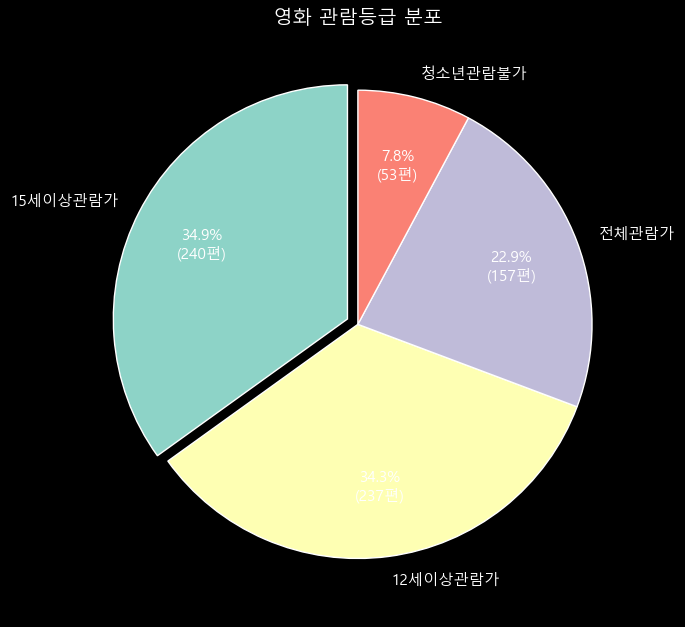

In [73]:
import matplotlib.pyplot as plt
import numpy as np

# 관람등급 카운트
rating_counts = result_df['GRAD_NM'].value_counts()

labels = rating_counts.index
sizes = rating_counts.values

# explode (가장 비중 큰 등급 강조)
explode = [0.05 if i == 0 else 0 for i in range(len(sizes))]

# 퍼센트 + 실제 수치 함께 표시 함수
def autopct_format(pct):
    absolute = int(pct/100.*np.sum(sizes))
    return f'{pct:.1f}%\n({absolute:,}편)'

plt.figure(figsize=(7,7))

wedges, texts, autotexts = plt.pie(
    sizes,
    labels=labels,
    explode=explode,
    autopct=autopct_format,
    startangle=90,
    pctdistance=0.7,        # 퍼센트 위치 조정
    labeldistance=1.1,      # 바깥 라벨 위치 조정
    textprops={'fontsize': 11},
    wedgeprops={'edgecolor': 'white'}
)

plt.title("영화 관람등급 분포", fontsize=14)
plt.tight_layout()
plt.show()

## 그래프 설명 및 해석
- 청소년 관람불가 등급이 전체 영화의 **34.9%(240편)**를 차지하며 압도적으로 높은 비중을 보임

- 뒤이어 15세 이상 관람가, 12세 이상 관람가, 전체 관람가 순으로 나타남

- 제작되는 영화의 절반 이상이 성인 대상 콘텐츠에 집중되어 있으며, 전체 관람가 영화의 비중이 가장 낮음을 확인

# 2. VIEWNG
## 2.1 영화 전체 산점도

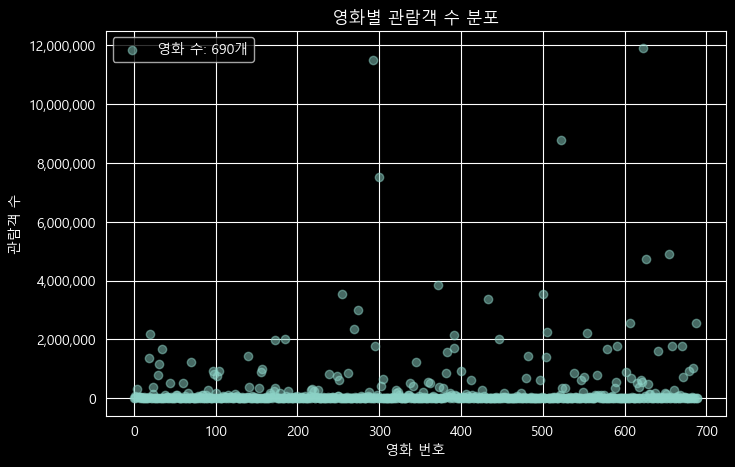

In [52]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker

plt.figure(figsize=(8,5))
num_points = len(result_df)

plt.scatter(
    np.arange(len(result_df)),        # 영화 개수만큼 0,1,2,... 자동 생성
    result_df['VIEWNG_NMPR_CO'],
    alpha=0.5,
    label=f"영화 수: {num_points}개"
)

plt.xlabel("영화 번호")  # x축 이름 제거
plt.ylabel("관람객 수")
plt.title("영화별 관람객 수 분포")

# 지수표기 제거
plt.ticklabel_format(style='plain', axis='y')

# 천 단위 콤마 표시
plt.gca().yaxis.set_major_formatter(
    ticker.StrMethodFormatter('{x:,.0f}')
)

plt.legend()
plt.show()

## 그래프 설명 및 해석
- 분석 내용: 총 690개의 영화 데이터를 대상으로 누적 관람객 수 분포를 산점도로 시각화하였습니다.

- 분석 결과: 극소수의 흥행작을 제외한 대부분의 데이터가 하위 구간에 밀집되어 있어, 점들이 심하게 겹쳐 보이는 현상이 나타났습니다.

- 조치 사항: 데이터의 편중을 해소하고 분포의 특징을 명확히 파악하기 위해, 특정 관객 수 구간을 기준으로 표본을 추출하여 추가 분석을 진행하였습니다.

## 2.2 총 관람객 1만명 이상 산점도

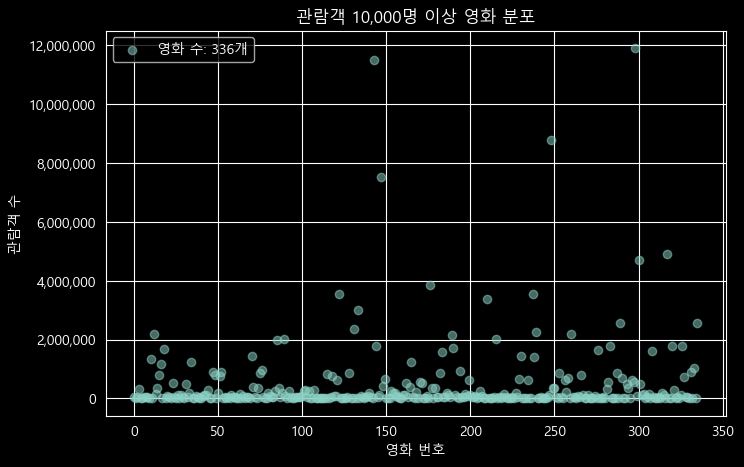

In [74]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker

# 관객수 1000명 이상만 필터링
filtered_df = result_df[result_df['VIEWNG_NMPR_CO'] >= 10000]

# 점 개수 계산
num_points = len(filtered_df)

plt.figure(figsize=(8,5))

plt.scatter(
    np.arange(num_points),
    filtered_df['VIEWNG_NMPR_CO'],
    alpha=0.5,
    label=f"영화 수: {num_points}개"
)

plt.xlabel("영화 번호")
plt.ylabel("관람객 수")
plt.title("관람객 10,000명 이상 영화 분포")

# 지수표기 제거
plt.ticklabel_format(style='plain', axis='y')

# 천 단위 콤마 표시
plt.gca().yaxis.set_major_formatter(
    ticker.StrMethodFormatter('{x:,.0f}')
)

plt.legend()
plt.show()

## 그래프 설명 및 해석
- 분석 내용: 누적 관람객 수 1만 명 이상을 기록한 336개의 데이터를 추출하여 산점도를 재구성하였습니다.

- 분석 결과: 전체 데이터 대비 가독성은 향상되었으나, 여전히 특정 구간 내 데이터 중첩 현상이 관찰되어 개별 데이터의 변별력을 확보하는 데 한계가 있었습니다.

- 조치 사항: 보다 뚜렷한 흥행 경향성을 확인하고자 분석 기준을 상향하여 심층 분석을 실시하였습니다.

## 2.3 총 관람객 100만명 이상 산점도

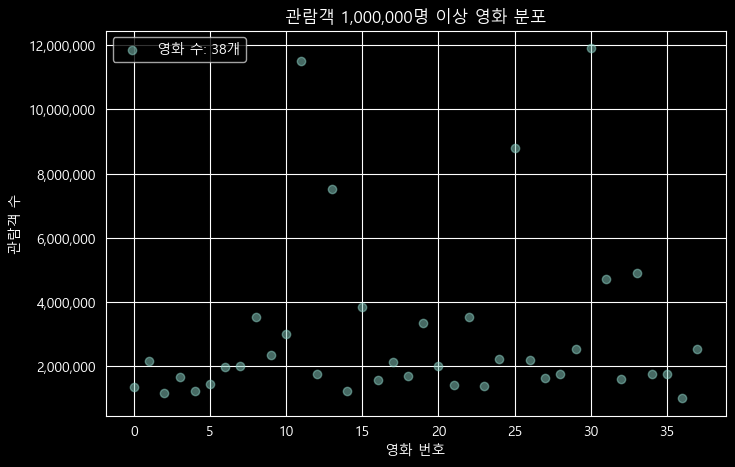

In [75]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker

# 관객수 1000명 이상만 필터링
filtered_df = result_df[result_df['VIEWNG_NMPR_CO'] >= 1000000]

# 점 개수 계산
num_points = len(filtered_df)

plt.figure(figsize=(8,5))

plt.scatter(
    np.arange(num_points),
    filtered_df['VIEWNG_NMPR_CO'],
    alpha=0.5,
    label=f"영화 수: {num_points}개"
)

plt.xlabel("영화 번호")
plt.ylabel("관람객 수")
plt.title("관람객 1,000,000명 이상 영화 분포")

# 지수표기 제거
plt.ticklabel_format(style='plain', axis='y')

# 천 단위 콤마 표시
plt.gca().yaxis.set_major_formatter(
    ticker.StrMethodFormatter('{x:,.0f}')
)

plt.legend()
plt.show()

## 그래프 설명 및 해석
- 분석 내용: 누적 관람객 수 100만 명 이상을 달성한 38개의 핵심 데이터를 분석하였습니다.

- 분석 결과: 총 개봉 영화 중 약 **48%**가 1만명을, 그리고 약 **5%**만이 100만 명 고지를 넘어서는 것으로 나타나, 영화 시장의 흥행 장벽이 매우 높음을 수치로 확인하였습니다.

- 시사점: 이 구간부터는 데이터 간의 간섭이 줄어들어 주요 흥행작들의 분포와 등급별 특성을 보다 정밀하게 파악할 수 있었습니다.

## 2.4 관람 등급별 관객수 누적분포 비교

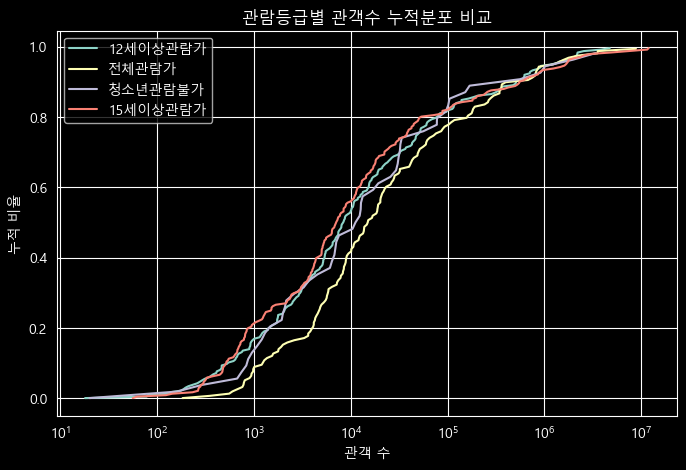

In [76]:
plt.figure(figsize=(8,5))

for grade in result_df['GRAD_NM'].unique():
    subset = result_df[result_df['GRAD_NM'] == grade]
    sorted_vals = np.sort(subset['VIEWNG_NMPR_CO'])
    yvals = np.arange(len(sorted_vals)) / float(len(sorted_vals))
    plt.plot(sorted_vals, yvals, label=grade)

plt.xscale("log")
plt.xlabel("관객 수")
plt.ylabel("누적 비율")
plt.title("관람등급별 관객수 누적분포 비교")
plt.legend()
plt.show()

## 분석결과
모든 등급에서 우측 꼬리가 긴 비대칭 분포가 나타났다. 이는 대부분의 영화가 비교적 낮은 관객 수 구간에 집중되어 있으며, 소수의 대형 흥행작이 시장을 견인하는 구조임을 의미한다.

중간 관객 수 구간에서 등급 간 차이가 일부 확인되었다.

전체관람가는 동일 누적비율 기준에서 약간 우측에 위치하는 경향을 보였으며, 이는 중간 규모 흥행에서 상대적으로 안정적인 성과를 보일 가능성을 시사한다.

고관객 구간에서는 네 등급 모두 유사한 형태로 수렴하는 경향을 보였다. 이는 관람등급 자체보다는 다른 요인들이 더 중요할 가능성을 시사한다.

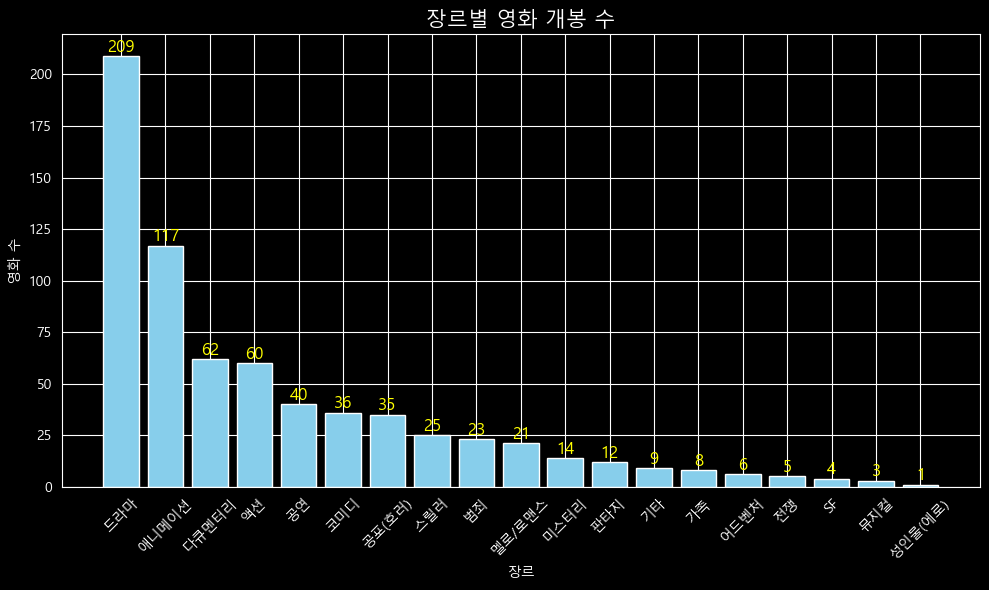

In [56]:
data = result_df['GENRE_NM'].value_counts() # 장르별 개수 카운트

# 그래프 그리기
plt.figure(figsize=(10, 6))
bars = plt.bar(data.index, data.values, color='skyblue')

# 그래프 꾸미기
plt.title('장르별 영화 개봉 수', fontsize=15)
plt.xlabel('장르')
plt.ylabel('영화 수')
plt.xticks(rotation=45) # 장르 이름이 길면 겹치니까 회전!

# 바 위에 숫자 표시 (첫 번째 이미지에서 썼던 방식이야)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{int(height)}', ha='center', va='bottom', color='yellow', fontsize=12)

plt.tight_layout()
plt.show()

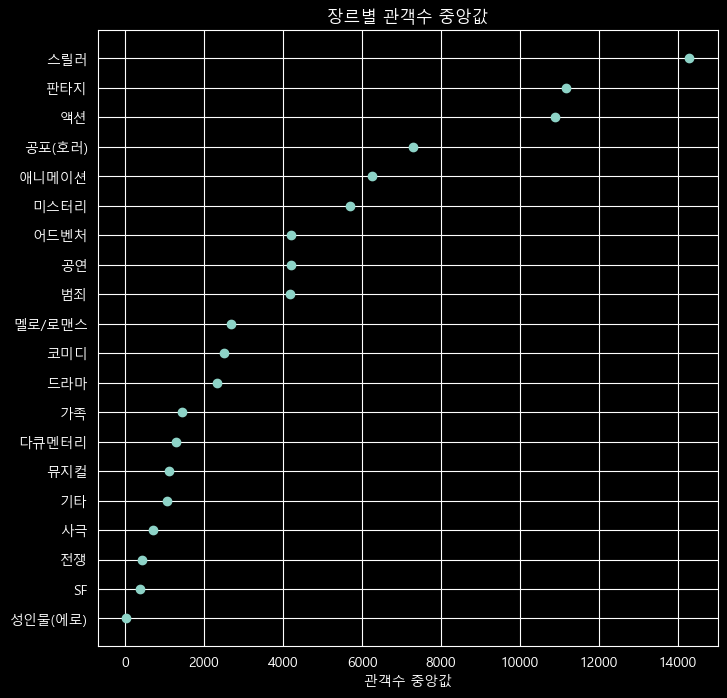

In [57]:
genre_stats = (
    movie_df
    .groupby('GENRE_NM')['VIEWNG_NMPR_CO']
    .median()
    .sort_values()
)

plt.figure(figsize=(8,8))

plt.scatter(
    genre_stats.values,
    genre_stats.index
)

plt.title("장르별 관객수 중앙값")
plt.xlabel("관객수 중앙값")
plt.show()

# 3. 국가별 : 국내/수입 영화

## 3.1 분류 기준 설정
- 영화진흥위원회(KOFIC) '한국 영화산업 결산'의 국가·권역 분류 체계를 참고해 국내, 미국, 중화권, 일본, 유럽, 기타로 단순화
- REGION을 기반으로 Korea는 Domestic, 그 외 국가는 Imported로 분류

In [58]:
# 어떤 값이 있는지 확인
display(movie_df['NLTY_NM'].unique())
# 몇 종류 인지 확인
display(movie_df['NLTY_NM'].nunique())
# 국가별 등장 횟수
movie_df['NLTY_NM'].value_counts().reset_index()

<StringArray>
[   '일본',    '한국',    '미국',  '이탈리아',    '중국',   '프랑스',    '대만',    '몽고',
   '캐나다',   '베트남',    '독일',   '헝가리',   '러시아', '말레이시아',    '호주',    '인도',
   '스페인',    '영국',    '홍콩',  '포르투갈',    '기타',  '네덜란드',  '노르웨이',   '덴마크',
   '멕시코',    '태국', '아르헨티나', '오스트리아',  '아일랜드', '우크라이나',   '폴란드',    '이란',
     nan]
Length: 33, dtype: str

32

,NLTY_NM,count
0,한국,730
1,미국,337
2,일본,270
3,프랑스,63
4,이탈리아,49
5,영국,45
6,독일,23
7,스페인,22
8,중국,18
9,캐나다,15


In [59]:
def classify_region_simple(country):
    if country == '한국':
        return 'Korea'

    # 미국 단일 그룹
    if country == '미국':
        return 'US'

    # 중화권
    if country in ['중국', '홍콩', '대만']:
        return 'China Region'

    # 일본
    if country == '일본':
        return 'Japan'

    # 유럽
    europe = [
        '영국','프랑스','독일','이탈리아','스페인','네덜란드','벨기에','폴란드','노르웨이',
        '스위스','덴마크','헝가리','오스트리아','포르투갈','체코','루마니아','스웨덴',
        '슬로바키아','핀란드','아이슬란드','에스토니아','아일랜드'
    ]
    if country in europe:
        return 'Europe'

    # 나머지 국가 전부 기타
    return 'Others'

movie_df['REGION'] = movie_df['NLTY_NM'].apply(classify_region_simple)

# 카테고리 순서 지정
region_order = ['Korea', 'US', 'Europe', 'Japan', 'China Region', 'Others']
region_sum = (
    movie_df.groupby('REGION', dropna=False)['VIEWNG_NMPR_CO']
    .sum()
    .reindex(region_order)   # 순서 맞추기
    .fillna(0)               # NaN → 0
)

In [60]:
# 적용
movie_df['REGION'] = movie_df['NLTY_NM'].apply(classify_region_simple)
# 문자열 정리
movie_df['REGION'] = movie_df['REGION'].astype(str).str.strip()

In [61]:
movie_df.groupby('REGION')['VIEWNG_NMPR_CO'].agg(['count', 'median', 'mean'])

,count,median,mean
REGION,,,
China Region,32,3834.5,11096.562500
Europe,237,1788.0,8878.434599
Japan,270,4260.5,28808.670370
Korea,730,2324.5,124632.153425
Others,64,2282.5,9245.484375
US,337,9953.0,176671.264095


In [62]:
movie_df['REGION'] = pd.Categorical(
    movie_df['REGION'],
    categories=region_order,
    ordered=True
)

color_map = {
    'Korea':        '#FF6B6B',  # 코랄 레드
    'US':           '#4D96FF',  # 클린 블루
    'Europe':       '#6BCB77',  # 민트 그린
    'Japan':        '#FFD93D',  # 라이트 옐로
    'China Region': '#845EC2',  # 바이올렛
    'Others':       '#B0B8C1'   # 뉴트럴 그레이
}


colors = [color_map[reg] for reg in region_sum.index]
palette = [color_map[r] for r in region_order]

## 3.2 국적권별 평균 관객 수 PointPlot
본 단계에서는 국가별 영화 1편당 평균 관객수를 비교하여
국내 영화와 수입 영화 간의 전반적인 흥행 규모 차이를 확인

- 분석 결과<br>
미국(US)의 평균 관객수가 가장 높게 나타났으며,
유럽(Europe)·일본(Japan)·한국(Korea)은 유사한 수준을 보였다.<br>
국내 영화의 경우 편수가 많아 다양한 규모의 작품이 존재함에 따라,
평균 관객수는 상대적으로 낮게 계산되는 경향이 확인되었다.
- 해석<br>
수입 영화(특히 미국)의 평균 관객수가 높은 이유는
주로 일정 규모 이상의 상업 영화만이 국내에 유입되는 구조적 특성 때문이다.<br>
반면 국내 영화는 대형 흥행작부터 초소형 저관객 영화까지 폭넓게 제작되기 때문에
평균값이 분산되어 낮아지는 효과가 존재한다.

- Domestic vs Imported 요약<br>
→ 수입 영화의 1편당 평균 관객수는 국내 영화보다 높은 편이며,
이는 선별 유입 구조에 따른 자연스러운 결과이다.

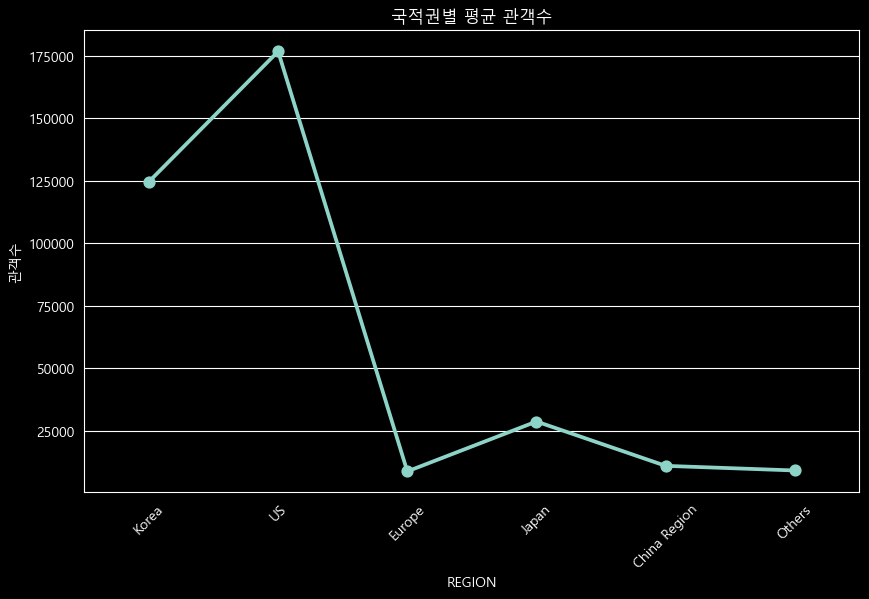

In [63]:
plt.figure(figsize=(10,6))

sns.pointplot(
    data=movie_df,
    x='REGION',
    y='VIEWNG_NMPR_CO',
    estimator='mean',
    errorbar=None
)
plt.title('국적권별 평균 관객수')
plt.ylabel('관객수')
plt.xticks(rotation=45)
plt.show()

## 3.3 국적별 중앙값 관객수 median barplot
평균만으로는 이상치(초대형 흥행작)의 영향을 받기 때문에
본 단계에서는 영화 1편당 전형적인 성과를 반영하는 중앙값 기준으로
국가별 관객수를 재검토<br>
- 분석 결과<br>
미국(US)과 유럽(Europe)은 각각 약 500명, 390명 수준으로 높은 중앙값을 보였다.<br>
한국(Korea)은 중앙값 59명, 일본(Japan)은 1명으로 매우 낮은 수치를 기록하였다.
- 해석<br>
한국·일본은 관객수가 거의 없는 저관객 영화가 매우 많은 구조를 가진다.
이에 따라 대형 흥행작이 존재하더라도 중앙값이 극단적으로 낮아진다.<br>
반면 미국·유럽은 중간 규모 이상의 상업 영화 중심으로 유입되기 때문에,
중앙값 자체가 상대적으로 높은 위치에서 형성된다.
- Domestic vs Imported 요약<br>
→ 국내 영화는 편수는 많지만 성과의 편차가 크며,
전형적인 1편의 관객수(중앙값)는 낮게 나타난다.
반면 수입 영화는 선별된 중·대형 작품 중심이므로 중앙값이 높다.

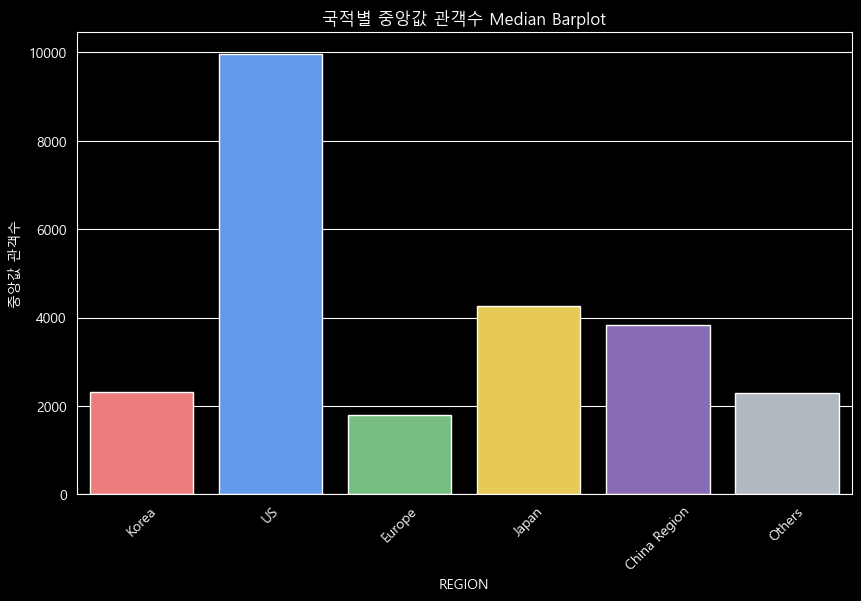

In [64]:
plt.figure(figsize=(10,6))
sns.barplot(
    data=movie_df,
    x='REGION',
    y='VIEWNG_NMPR_CO',
    hue='REGION',
    estimator=np.median,
    errorbar=None,
    palette=palette,
    dodge=False,
    legend=False
)
plt.title('국적별 중앙값 관객수 Median Barplot')
plt.ylabel('중앙값 관객수')
plt.xticks(rotation=45)
plt.show()

## 3.4 국적권별 관객수 분포 Boxplot
국가별 관객수 분포(Boxplot)를 통해
국내·수입 영화의 흥행 편차 및 이상치 구조를 시각적으로 비교<br>

- 분석 결과<br>

한국·일본의 분포는 전체적으로 아래쪽에 밀집해 있어
저관객 영화 비중이 매우 높은 구조임을 확인할 수 있다.
이와 동시에 상단부에는 대형 흥행작(outlier)이 길게 존재하여
양극화(흥행 편차) 현상이 뚜렷하게 나타난다.<br>

미국은 박스 자체가 상단 영역에 위치하며,
중간 규모 작품도 꾸준히 일정 관객을 확보하는 안정적 구조를 형성한다.

- 해석<br>
→ 국내 영화 시장은 공급량이 크고 다양한 규모의 작품이 제작되며,
특히 저관객 작품이 많이 생산되는 특성이 있다.
반면 수입 영화는 비교적 규모 있는 작품 중심으로 유입되기 때문에
전체 분포가 더 안정적으로 나타난다.

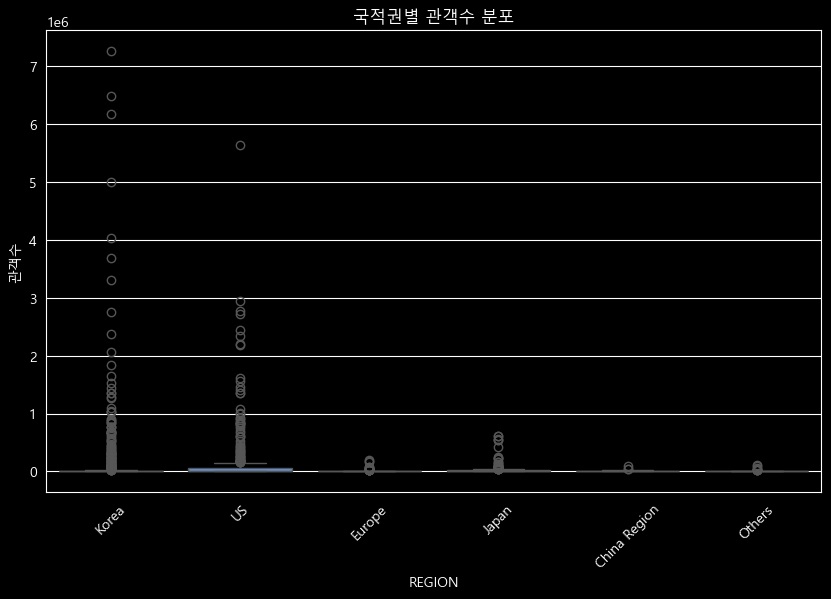

In [65]:
plt.figure(figsize=(10,6))

sns.boxplot(
    data=movie_df,
    x='REGION',
    y='VIEWNG_NMPR_CO',
    hue='REGION',      # seaborn 0.14 권장: palette 사용 시 hue 명시
    dodge=False,       # 박스 겹치지 않게
    legend=False,      # 범례 숨김
    palette=palette
)

plt.title('국적권별 관객수 분포')
plt.ylabel('관객수')
plt.xticks(rotation=45)
plt.show()

## 3.5 국적별 누적 관객수 비중 pie/donut
영화 시장의 전체 규모 파악을 위해
국가별 누적 관객수 비중을 도넛 그래프로 분석

- 분석 결과<br>

전체 누적 관객수 대비 한국(Korea)은 약 59%,
미국(US)은 약 33%의 비중을 차지한다.

나머지 지역(Europe, Japan, China Region, Others)의 비중은 상대적으로 미미하다.

- 해석<br>

본 결과는 국내 영화 공급량 자체가 많고,
여기에 중·대형 흥행작이 꾸준히 배출되기 때문에
전체 시장 점유율에서 한국이 압도적으로 높아지는 구조를 보여준다.

앞선 평균/중앙값 분석에서 수입 영화가 1편당 성과에서는 우세했지만,
전체 시장 규모(총합 기준)에서는 국내 영화가 절대 우위를 점하고 있다.

- 요약<br>

→ 영화 1편 기준 성과는 수입 우세, 시장 전체 규모는 국내 우세라는
이중 구조가 확인된다.

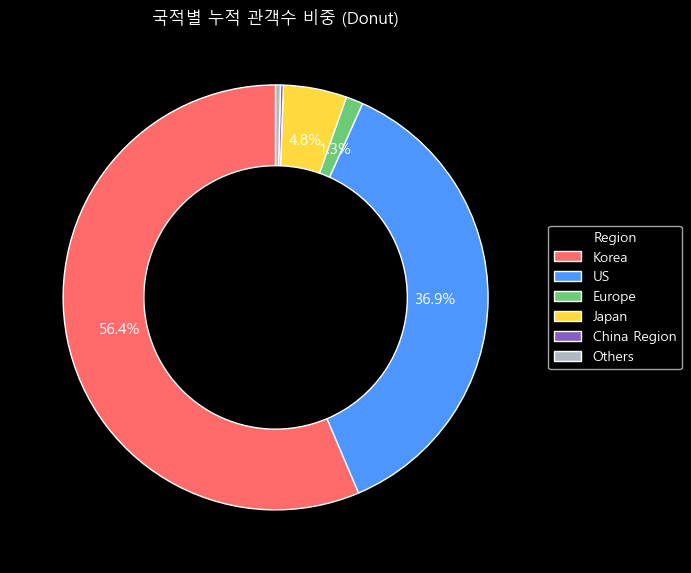

In [66]:
def autopct_fmt(pct):
    return '%.1f%%' % pct if pct >= 1 else ''   # 1% 미만 퍼센트 숨김

plt.figure(figsize=(7,7))

# 도넛 생성 (라벨 없이 퍼센트만)
wedges, texts, autotexts = plt.pie(
    region_sum,
    labels=None,
    autopct=autopct_fmt,
    startangle=90,
    wedgeprops={'width': 0.38},
    colors=colors,
    pctdistance=0.75,
    textprops={'fontsize': 11}
)

# 범례 (라벨 대신 여기서 정리)
plt.legend(
    wedges,
    region_sum.index,
    title='Region',
    loc='center left',
    bbox_to_anchor=(1.0, 0.5)
)

plt.title('국적별 누적 관객수 비중 (Donut)')
plt.tight_layout()
plt.show()

## 3.6 국적별 영화 편수 countplot
국가별 영화 공급량을 확인하기 위해
REGION 별 편수를 시각화하였다.

- 분석 결과

국내 영화(Korea)의 편수가 가장 많고,
뒤이어 Japan → US → Europe → Others 순으로 나타났다.

- 해석

국내 시장은 다양한 규모의 작품이 대량 제작되는 산업 구조를 가진 반면,
수입 영화는 선별된 일부 작품들만 유입되는 특성을 가진다.

- Domestic vs Imported 요약

→ 편수 기준으로는 국내 영화의 비중이 압도적이다.

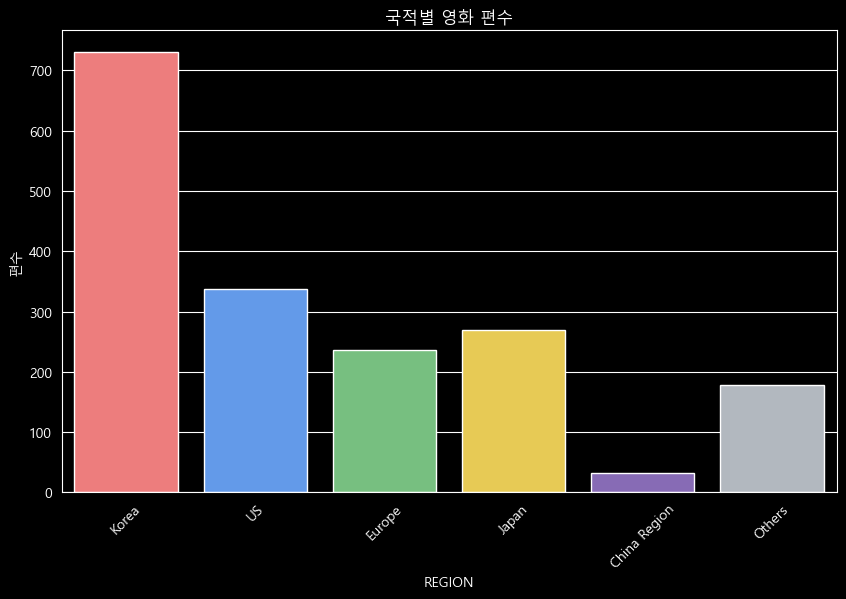

In [67]:
plt.figure(figsize=(10, 6))

sns.countplot(
    data=movie_df,
    x='REGION',
    hue='REGION',     # palette 사용 시 hue 필수
    dodge=False,      # 막대 겹치지 않게
    legend=False,     # 범례 숨김
    palette=palette
)

plt.title('국적별 영화 편수')
plt.ylabel('편수')
plt.xticks(rotation=45)
plt.show()

# 4. 배급사별
1. 배급사별 영화 수
2. 배급사별 총 관객수
3. 배급사별 평균 관객수 (핵심)
4. 흥행 분포 분석 (boxplot)
5. 100만 이상 영화 비율

1️⃣ 1단계: 어떤 지표를 볼 것인가?
✅ 1. 관객수 vs 매출액 — 뭘 봐야 할까?

✔ 기본은 관객수
✔ 보조로 매출액

이유:

매출은 티켓 가격 영향을 받음

관객수는 순수한 “흥행 규모” 지표

유통사 영향력 보기엔 관객수가 더 직관적

👉 결론:

주 지표: 총 관객수

보조 지표: 총 매출액, 평균 매출액

2️⃣ 유통사별 EDA에서 꼭 해야 할 것들
① 유통사별 영화 수
유통사별 제작/배급 영화 개수


왜 중요?
→ 대형 유통사는 많이 배급해서 총 관객이 클 수 있음
→ 단순 합계 비교는 왜곡 가능

📌 시각화:

bar chart (상위 10개 유통사)

② 유통사별 총 관객수
groupby(유통사) → 관객수 합계


이건 “시장 점유율” 느낌이에요.

📌 같이 해보면 좋은 것:

전체 관객 중 각 유통사 비율 (%)

파이차트 or 누적 막대

③ 유통사별 평균 관객수 (중요 ⭐)

이게 진짜 핵심입니다.

총관객수 / 영화 수


→ 한 편당 평균 흥행력

왜 중요?

대기업은 많이 배급

하지만 평균은 떨어질 수도 있음

소규모 유통사가 평균은 더 높을 수도 있음

📌 이건 반드시 해야 함

④ 흥행 분포 (히스토그램 or 박스플롯)

유통사별 관객수 분포

특정 유통사는 “대박 영화만 몇 개”

어떤 유통사는 “중박 영화 다수”

📌 boxplot 추천

x: 유통사
y: 관객수


→ 아웃라이어 확인 가능

⑤ 100만 이상 영화 비율

흥행 기준 정해서 보기 👇

예:

100만 이상

500만 이상

1000만 이상

(100만 이상 영화 수) / 전체 영화 수


→ 유통사의 “히트 확률”

이거 교수님들이 되게 좋아합니다 👀

## 4-1.배급사별 영화 수
- “기타”가 압도적으로 많은 것은 중소 배급사가 매우 많다는 의미
- 하지만 개별 영향력은 낮아 상위 배급사 분석에서 제외
- 시장 구조는 소수 대형사 중심

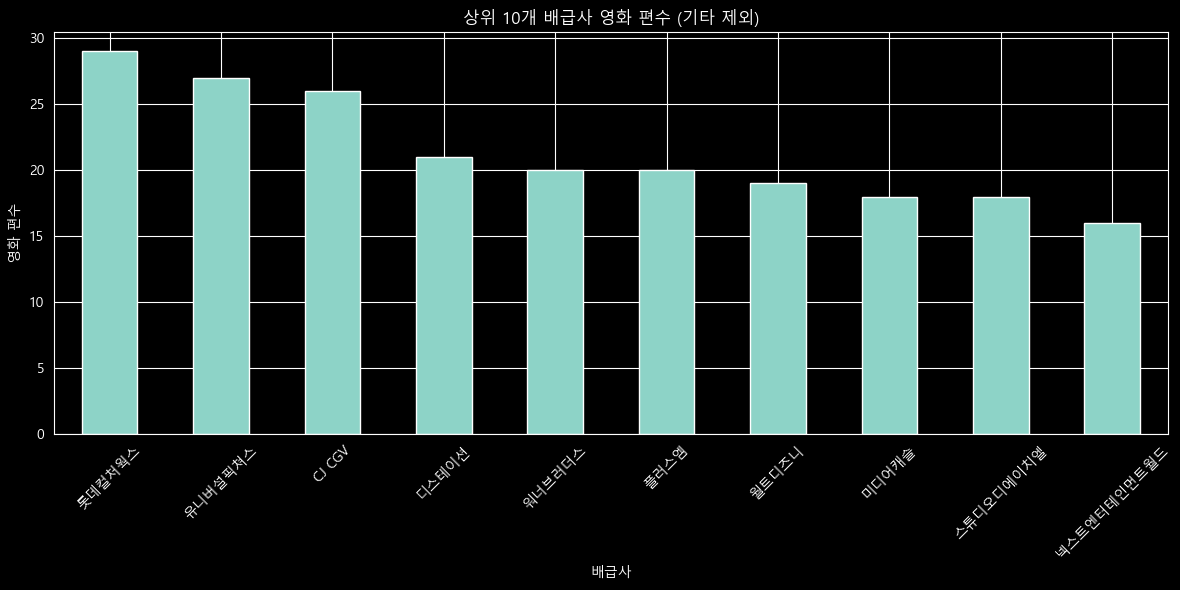

In [68]:
# 배급사별 영화 수 '기타'항목 제외 상위10건
plt.figure(figsize=(12,6))
top10 = result_df[result_df['DIST_TOP30'] != '기타']['DIST_TOP30'].value_counts().head(10)

top10.plot(kind='bar')

plt.title('상위 10개 배급사 영화 편수 (기타 제외)')
plt.xlabel('배급사')
plt.ylabel('영화 편수')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

## 4-2. 배급사별 총 관객수(점유율)

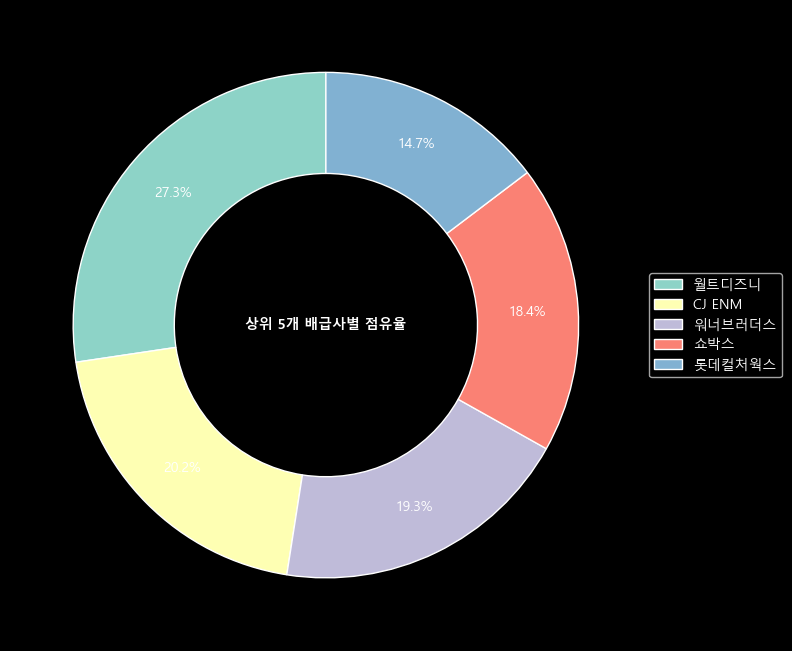

In [69]:
dist_audience_sum = (
    result_df[result_df['DIST_TOP30'] != '기타']
    .groupby('DIST_TOP30')['VIEWNG_NMPR_CO']
    .sum()
    .sort_values(ascending=False)
)

top10_audience = dist_audience_sum.head(5)

plt.figure(figsize=(8,8))

wedges, texts, autotexts = plt.pie(
    top10_audience,
    labels=None,
    autopct='%1.1f%%',
    startangle=90,
    wedgeprops=dict(width=0.4),   # 도넛 모양
    pctdistance=0.80,
)

plt.legend(
    wedges,
    top10_audience.index,
    loc="center left",
    bbox_to_anchor=(1, 0.5)
)


plt.text(0, 0, '상위 5개 배급사별 점유율', ha='center', va='center', fontsize=10, fontweight='bold')
plt.tight_layout()
plt.show()

## 4-3. 배급사별 평균 관객 수
- 영화 수는 많지만 평균 낮다 → 다작 전략
- 영화 수 적지만 평균 높다 → 선택과 집중

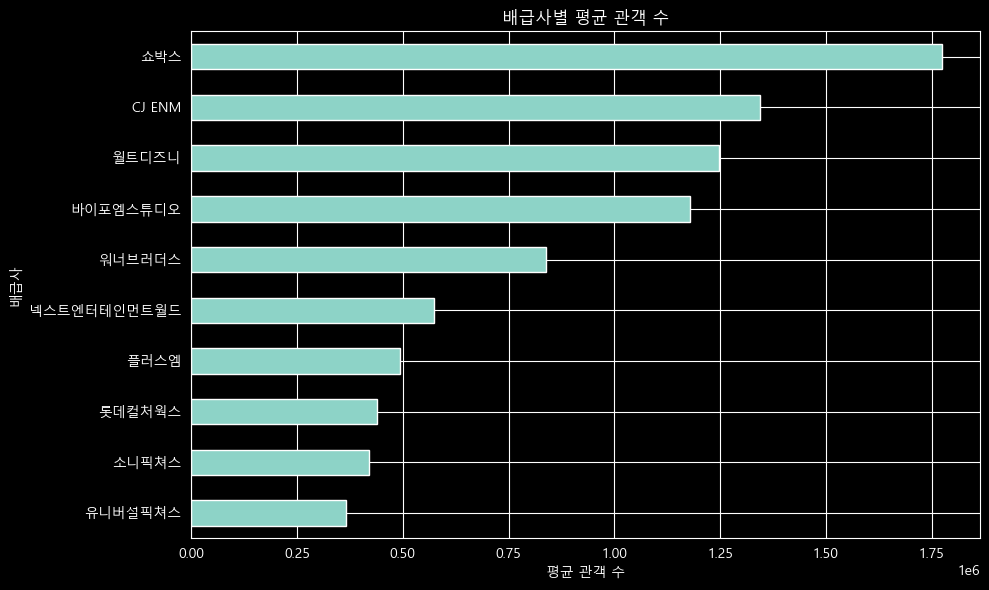

In [70]:
# 1. 배급사별 총 관객수 (기타 제외)
dist_total = (
    result_df[result_df['DIST_TOP30'] != '기타']
    .groupby('DIST_TOP30')['VIEWNG_NMPR_CO']
    .sum()
    .sort_values(ascending=False)
)

# 2. 상위 10개 배급사 리스트
top10_list = dist_total.head(10).index

# 3. 상위 10개만 필터링 후 평균 관객수 계산
dist_mean = (
    result_df[result_df['DIST_TOP30'].isin(top10_list)]
    .groupby('DIST_TOP30')['VIEWNG_NMPR_CO']
    .mean()
    .sort_values(ascending=True)   # 가로막대는 오름차순이 보기 좋음
)

# dist_mean

plt.figure(figsize=(10,6))

dist_mean.plot(kind='barh')

plt.title('배급사별 평균 관객 수')
plt.xlabel('평균 관객 수')
plt.ylabel('배급사')

plt.tight_layout()
plt.show()

## 4-4. 배급사별 관객수 분포

<Figure size 1600x800 with 0 Axes>

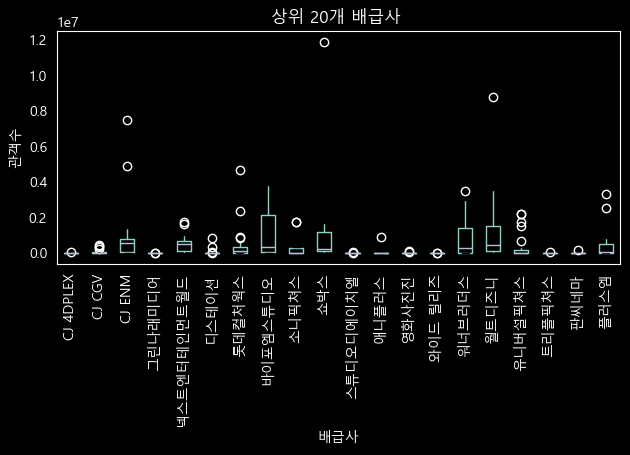

In [71]:
# 상위 20개 배급사 데이터만 필터링
top20_list = dist_total.head(20).index
top20_df = result_df[result_df['DIST_TOP30'].isin(top20_list)]

plt.figure(figsize=(16, 8))

top20_df.boxplot(
    column='VIEWNG_NMPR_CO',
    by='DIST_TOP30',
    grid=False
)

plt.title('상위 20개 배급사 ')
plt.suptitle('')  # pandas 기본 타이틀 제거
plt.xlabel('배급사')
plt.ylabel('관객수')

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## 4-5. 배급사별 100만, 500만, 1000만 이상 영화

1️⃣ 대부분 배급사는 100만 미만 비율이 높음

→ 흥행 실패 위험 높음

2️⃣ 일부 대형 배급사는 500만 이상 비율이 상대적으로 높음

→ 블록버스터 중심 전략

3️⃣ 1000만 이상 영화는 특정 배급사에 집중

→ 시장 독점 구조 가능성

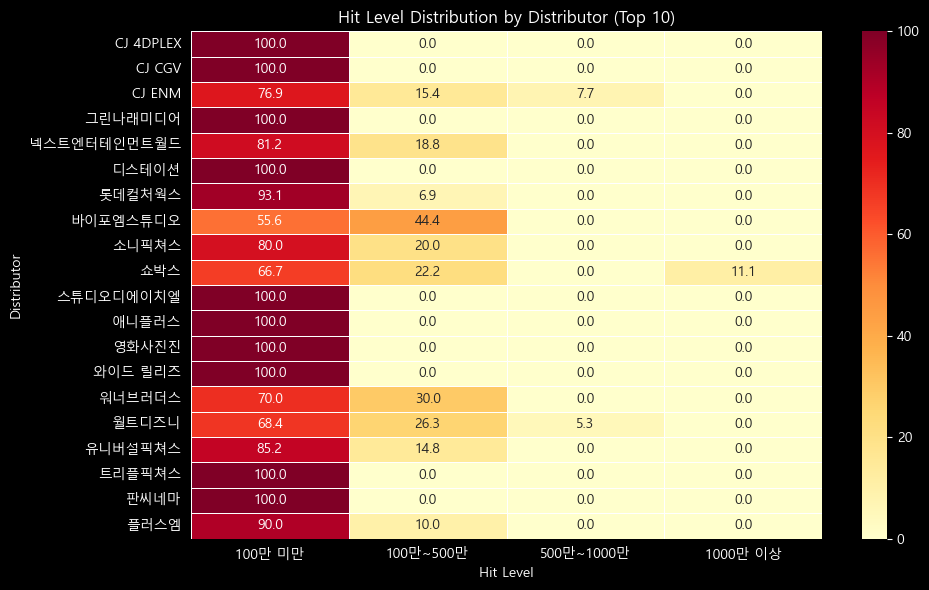

In [72]:
# 1. 상위 10개 배급사 (총 관객수 기준, 기타 제외)

top20_df = result_df[result_df['DIST_TOP30'].isin(top20_list)].copy()

# 2. 흥행 등급 컬럼 생성 (겹치지 않게)
conditions = [
    top20_df['VIEWNG_NMPR_CO'] >= 10000000,
    (top20_df['VIEWNG_NMPR_CO'] >= 5000000) & (top20_df['VIEWNG_NMPR_CO'] < 10000000),
    (top20_df['VIEWNG_NMPR_CO'] >= 1000000) & (top20_df['VIEWNG_NMPR_CO'] < 5000000),
    top20_df['VIEWNG_NMPR_CO'] < 1000000
]

choices = ['1000만 이상', '500만~1000만', '100만~500만', '100만 미만']

# top10_df['HIT_LEVEL'] = np.select(conditions, choices)
# TypeError 발생으로 np.select() 사용 안 함
top20_df['HIT_LEVEL'] = pd.cut(
    top20_df['VIEWNG_NMPR_CO'],
    bins=[-1, 999999, 4999999, 9999999, float('inf')],
    labels=['100만 미만', '100만~500만', '500만~1000만', '1000만 이상']
)

# 3. 배급사별 비율 계산
hit_ratio = (
    top20_df
    .groupby(['DIST_TOP30', 'HIT_LEVEL'])
    .size()
    .unstack(fill_value=0)
)

# 비율(%)로 변환
hit_ratio_pct = hit_ratio.div(hit_ratio.sum(axis=1), axis=0) * 100

hit_ratio_pct = hit_ratio_pct[['100만 미만','100만~500만','500만~1000만','1000만 이상']]

plt.figure(figsize=(10,6))

sns.heatmap(
    hit_ratio_pct,
    annot=True,          # 숫자 표시
    fmt=".1f",
    cmap="YlOrRd",       # 색상 (노랑→빨강)
    linewidths=0.5
)

plt.title("Hit Level Distribution by Distributor (Top 10)")
plt.xlabel("Hit Level")
plt.ylabel("Distributor")

plt.tight_layout()
plt.show()